

# What could you do if you don't have Enough DATA?

## In case of imbalanced dataset

### Demonstrating source code for Deep Learning meetup in Budapest 28.01.2019

Notebook created by Miklos Toth ( miklos.toth83@gmail.com )



In [2]:
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline


### Let's create some datapoints. Please note the number of majority and minority classes.

In [4]:
num_majority_class=1000
num_minority_class=150

majority_class_flag=-1.0
minority_class_flag=1.0

def generate_data(num_majority_class,num_minority_class):
    np.random.seed(42)
    # multiply by 2 to have higher variance!
    x1=np.random.standard_normal(num_majority_class)*2.0
    x2=np.random.standard_normal(num_majority_class)*2.0
    xdata=pd.DataFrame(data=[x1,x2]).transpose()
    xdata=xdata.rename(index=str, columns={0: "x1", 1: "x2"})
    xdata['category']=majority_class_flag
    xdata.head()

    # you can plaz with this the following way:
    # multiply by a number under 1 to have less variance!
    # multiply by a number above 1 to have more variance!
    x1=np.random.standard_normal(num_minority_class)*1.0+2.5
    x2=np.random.standard_normal(num_minority_class)*1.0+2.5
    y2=np.full(num_minority_class,minority_class_flag)
    cat2=pd.DataFrame(data=[x1,x2,y2]).transpose()
    cat2=cat2.rename(index=str, columns={0: "x1", 1: "x2", 2:"category"})
    xdata=xdata.append(cat2)
    xdata=xdata.reset_index(drop=True)
    return xdata

xdata=generate_data(num_majority_class,num_minority_class)
xdata.head()

,x1,x2,category
0,0.993428,2.798711,-1.0
1,-0.276529,1.849267,-1.0
2,1.295377,0.119261,-1.0
3,3.046060,-1.293874,-1.0
4,-0.468307,1.396447,-1.0


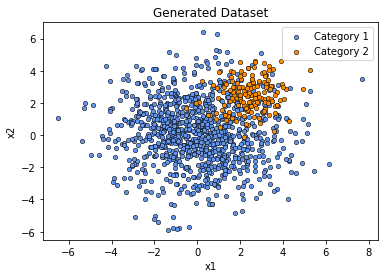

In [5]:

def plot_data_points(plotdatax):
    ax = plotdatax[plotdatax['category']==majority_class_flag].plot.scatter(x="x1",y="x2", color='cornflowerblue',edgecolor='black', linewidth='0.5',marker="o",s=20, label='Category 1');
    plotdatax[plotdatax['category']==minority_class_flag].plot.scatter(x="x1",y="x2", color='darkorange',edgecolor='black', linewidth='0.5', label='Category 2',s=20, ax=ax);
    return ax
plot_data_points(xdata)
plt.title("Generated Dataset")

plt.show()

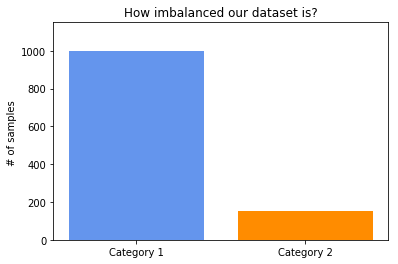

In [6]:

def show_balance_of_classes(xdata):
    total_size=len(xdata)
    size_cat1=len(xdata[xdata['category']==majority_class_flag])
    size_cat2=len(xdata[xdata['category']==minority_class_flag])
    fig, ax = plt.subplots()
    ind = np.arange(1, 3)

    cat1, cat2 = plt.bar(ind, [size_cat1,size_cat2])
    cat1.set_facecolor('cornflowerblue')
    cat2.set_facecolor('darkorange')

    ax.set_xticks(ind)
    ax.set_xticklabels(['Category 1', 'Category 2'])
    ax.set_ylim([0, total_size])
    ax.set_ylabel('# of samples ')
    ax.set_title('How imbalanced our dataset is?')

    plt.show()
    
show_balance_of_classes(xdata)

### Create Train and Eval set

In [8]:

data=xdata.copy()
y=data.pop('category')
X=data
x_train, x_eval, y_train, y_eval = train_test_split(X,y,test_size=0.3, random_state = 42)
    


## Let's solve this first with Tensorflow and Linear SVM
Lets create the loss function with tensorflow graph so later we can modify it. 


### Create Placeholders and Variables

In [9]:
import tensorflow as tf
tf.reset_default_graph()
ph_xdata = tf.placeholder(shape=[None,2],dtype=tf.float32)
ph_ytrue = tf.placeholder(shape=[None,1],dtype=tf.float32)
ph_weights= tf.placeholder(shape=[None,1],dtype=tf.float32)

#let's set some random init values
W = tf.get_variable("W", dtype=tf.float32,initializer=tf.constant([[23.],[ 42.]]))
b = tf.get_variable("b", dtype=tf.float32,initializer=tf.constant([[5.]]))


### Creating Loss function

SVM uses the Hinge loss, you may remember the Hinge loss is:<br/>
<img src="svm_loss.png"
     alt="svm_loss_info"
/>
<br/>

where<br/>

<img src="svm_loss_info.png"
     alt="svm_loss_info"
     /><br/>

Let's implement this loss with tensorflow:

In [10]:

w_norm=tf.square(tf.norm(W))
alpha=tf.constant([0.1])
C=tf.constant(1.0)

model_output=tf.subtract(tf.matmul(ph_xdata,W),b)
substract_term=tf.subtract(1.0,tf.multiply(model_output,ph_ytrue))

class_term=tf.multiply(C,tf.reduce_mean(tf.maximum(0.0,substract_term)))
hinge_loss_svm=tf.add(class_term,tf.multiply(alpha,w_norm))



### Lets train on our data


In [11]:

def train(loss_candidate,x_train,y_train,x_eval,y_weights=None):
    learning_rate=0.015
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.minimize(loss_candidate)
    # The init is done above, therefore no init needed.
    #init = tf.global_variables_initializer()
    with tf.Session() as sess:

        #sess.run(init)
        sess.run(W.initializer)
        sess.run(b.initializer)

        epochs = 10000
        loss_vec=[]
        for i in range(epochs):
            if(y_weights is None):
                sess.run(train_step,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train]) })
                temp_loss=sess.run(loss_candidate,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train])})
            else:
                sess.run(train_step,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train]),ph_weights:y_weights })
                temp_loss=sess.run(loss_candidate,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train]),ph_weights:y_weights })
            
            loss_vec.append(temp_loss)
            if(i%300==0):
                # Fetch Back Results
                [[a1],[a2]] = sess.run(W)
                [[b1]]  = sess.run(b)
                temp_slope=-a2/a1
                temp_intercept=b1/a1
                print("loss:",temp_loss,"slope:",temp_slope,"intercept:",temp_intercept,"W",a1,a2,"b",b1)

        # Fetch back the results
        [[w1],[w2]] = sess.run(W)
        [[b1]]  = sess.run(b)
        
        eval_predictions=sess.run(model_output,feed_dict={ph_xdata : x_eval})


    final_slope=-w2/w1
    final_intercept=b1/w1
    
    eval_predictions=pd.DataFrame(eval_predictions)[0].apply(lambda x: -1 if x<0 else 1)
    
    #print(eval_predictions)
    print("slope:",final_slope)
    print("intercept:",final_intercept)
    return final_slope,final_intercept,eval_predictions
    
# lets use our predefined hinge loss for the training.
final_slope,final_intercept,eval_predictions=train(hinge_loss_svm,x_train,y_train,x_eval)

loss: [259.58282] slope: -1.8259685 intercept: 0.21836054 W 22.927094 41.86415 b 5.0063725
loss: [39.72075] slope: -1.7630723 intercept: 0.79915774 W 8.540832 15.058104 b 6.8254714
loss: [3.9559975] slope: -1.6092081 intercept: 3.0254376 W 2.714087 4.367531 b 8.211301
loss: [0.79574883] slope: -1.2371881 intercept: 6.6717415 W 1.2451559 1.540492 b 8.307359
loss: [0.72165155] slope: -1.0083681 intercept: 6.295525 W 1.2445856 1.2550005 b 7.83532
loss: [0.668216] slope: -0.9300078 intercept: 5.9765162 W 1.2312164 1.1450409 b 7.358385
loss: [0.619113] slope: -0.88711554 intercept: 5.7349844 W 1.2024338 1.0666977 b 6.8959394
loss: [0.57348347] slope: -0.8726118 intercept: 5.5920105 W 1.1534692 1.0065309 b 6.450212
loss: [0.5316979] slope: -0.86797285 intercept: 5.487397 W 1.0977733 0.9528374 b 6.023918
loss: [0.49422607] slope: -0.8703585 intercept: 5.4582343 W 1.0301932 0.89663744 b 5.623036
loss: [0.46023] slope: -0.85776156 intercept: 5.358073 W 0.97796553 0.8388612 b 5.2400107
loss: [0.

In [15]:

print(classification_report(y_eval, eval_predictions, target_names=['Category 1','Category 2']))


              precision    recall  f1-score   support

  Category 1       0.90      0.99      0.94       307
  Category 2       0.50      0.11      0.17        38

   micro avg       0.89      0.89      0.89       345
   macro avg       0.70      0.55      0.56       345
weighted avg       0.86      0.89      0.86       345



<p style="color:red"> The f1-score, and recall is very low for category 2</p>

#### Conclusion: the algorithm is very bad in recognizing category 2

<br/>

#### Let's draw the decision boundary:

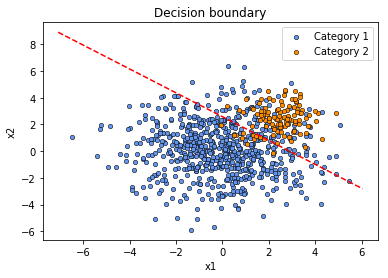

In [32]:
def abline(ax,slope, intercept):
    """Plot a line from slope and intercept"""
    axes = ax#plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color='r')
    axes.set_title("Decision boundary")
    
def show_decision_boundary(final_slope,final_intercept,x_train=x_train,y_train=y_train):
    plotdatax=x_train.copy()
    plotdatax['category']=y_train

    ax=plot_data_points(plotdatax)
    abline(ax,final_slope,final_intercept)
    plt.show()

show_decision_boundary(final_slope,final_intercept)

### What to do now? Solution 1: Let's introduce weights for the loss

First we generate some weights

In [17]:
def gen_weights(y,weight):
    if y==minority_class_flag:
        return weight
    else:
        return 1.0
generated_weights=y_train.apply(lambda y:gen_weights(y,2.5))
y_weights=np.transpose([generated_weights])
print("lets look at the head of the weights:")
np.transpose(y_weights[:50])

lets look at the head of the weights:


array([[1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 2.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 2.5, 1. , 1. , 1. , 2.5, 1. , 1. , 1. ,
        1. , 1. , 2.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]])

Modify the default loss, multiply with the prepared weights

In [18]:

weighted_class_term=tf.reduce_mean(tf.maximum(0.0,tf.multiply(ph_weights,substract_term)))
weighted_loss_svm=tf.add(weighted_class_term,tf.multiply(alpha,w_norm))


Train with the new weighted loss function:

In [19]:
final_slope,final_intercept,eval_predictions=train(weighted_loss_svm,x_train,y_train,x_eval,y_weights)

loss: [259.58282] slope: -1.8259685 intercept: 0.21836054 W 22.927094 41.86415 b 5.0063725
loss: [39.72075] slope: -1.7630723 intercept: 0.79915774 W 8.540832 15.058104 b 6.8254714
loss: [4.0158024] slope: -1.6046041 intercept: 3.0053868 W 2.7276516 4.376801 b 8.197648
loss: [1.1868955] slope: -1.1335627 intercept: 5.066499 W 1.586813 1.798752 b 8.039587
loss: [1.0434773] slope: -0.91672754 intercept: 4.512016 W 1.6194228 1.4845694 b 7.306861
loss: [0.9312444] slope: -0.87208414 intercept: 4.354678 W 1.5205976 1.326089 b 6.621713
loss: [0.83443093] slope: -0.85988766 intercept: 4.2590327 W 1.4047703 1.2079446 b 5.9829626
loss: [0.75075185] slope: -0.8715312 intercept: 4.195331 W 1.284312 1.119318 b 5.388114
loss: [0.67908275] slope: -0.88946915 intercept: 4.139793 W 1.1687111 1.0395324 b 4.8382215
loss: [0.61912614] slope: -0.8993993 intercept: 4.0714674 W 1.0649936 0.9578545 b 4.3360868
loss: [0.5692574] slope: -0.8982674 intercept: 3.985891 W 0.9732274 0.8742184 b 3.8791783
loss: [0.

In [20]:
print(classification_report(y_eval, eval_predictions, target_names=['Category 1','Category 2']))


              precision    recall  f1-score   support

  Category 1       0.97      0.87      0.92       307
  Category 2       0.43      0.82      0.56        38

   micro avg       0.86      0.86      0.86       345
   macro avg       0.70      0.84      0.74       345
weighted avg       0.91      0.86      0.88       345



<p style="color:green"> The f1-score, and recall is better for category 2</p>
Of course there are some drawbacks on the other side... Still the weighted avg for prec, recall, f1 are better then at the previous model. 

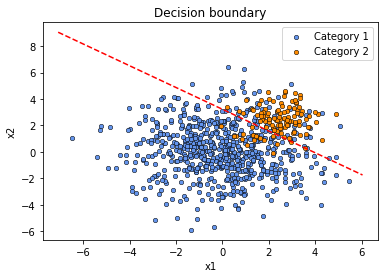

In [21]:
show_decision_boundary(final_slope,final_intercept)

### Solution 2 A: Undersampling: Let's use the original loss but with less samples from category 1
(This solution is in most cases not really recommended as valuable original samples will be thorwn away)


In [22]:
undersampled_data=xdata[xdata['category']==majority_class_flag].sample(n=num_minority_class,random_state=42)
undersampled_data=undersampled_data.append(xdata[xdata['category']==minority_class_flag])

data=undersampled_data.copy()
y=data.pop('category')
X=data
x_train_u, x_eval_u, y_train_u, y_eval_u = train_test_split(X,y,test_size=0.3, random_state = 42)


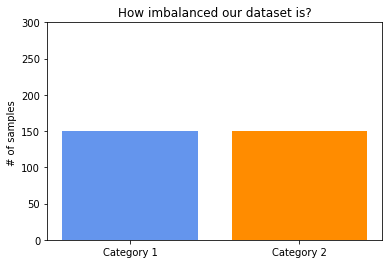

In [23]:
show_balance_of_classes(undersampled_data)

In [24]:

# the original eval set is used for predictions!
# using the original loss!
final_slope,final_intercept,eval_predictions=train(hinge_loss_svm,x_train_u,y_train_u,x_eval)


loss: [242.25392] slope: -1.8260705 intercept: 0.21821226 W 22.928854 41.869705 b 5.003357
loss: [38.805634] slope: -1.8253247 intercept: 0.67387736 W 8.857614 16.16802 b 5.968945
loss: [5.4157696] slope: -1.7507918 intercept: 2.0608475 W 3.2709212 5.726702 b 6.74087
loss: [1.077882] slope: -1.4180286 intercept: 4.6271353 W 1.4737334 2.089796 b 6.819164
loss: [0.88678706] slope: -1.0729805 intercept: 4.0601497 W 1.4948069 1.6038986 b 6.06914
loss: [0.75822103] slope: -1.0087004 intercept: 3.8215892 W 1.3976635 1.4098237 b 5.3412957
loss: [0.6483752] slope: -0.97429174 intercept: 3.644125 W 1.2808146 1.2478871 b 4.6674485
loss: [0.5578897] slope: -0.9777708 intercept: 3.5525796 W 1.1425582 1.1171601 b 4.059029
loss: [0.48412365] slope: -0.9526251 intercept: 3.3876784 W 1.0356946 0.98662865 b 3.5086002
loss: [0.42593664] slope: -0.93297774 intercept: 3.233659 W 0.93420017 0.87158793 b 3.0208848
loss: [0.3843056] slope: -0.94515675 intercept: 3.1319993 W 0.83315915 0.787466 b 2.609454
los

#### Of course, the classification report is done on the original eval set!

In [25]:
print(classification_report(y_eval, eval_predictions, target_names=['Category 1','Category 2']))

              precision    recall  f1-score   support

  Category 1       0.99      0.82      0.90       307
  Category 2       0.40      0.95      0.56        38

   micro avg       0.84      0.84      0.84       345
   macro avg       0.70      0.89      0.73       345
weighted avg       0.93      0.84      0.86       345



<p style="color:green">With undersampling we have similar results as with the weighted loss, and now we used the original loss. </p>
So this means, just by undersampling we could reach a better result!<br/>
Lets draw the decision boundary:

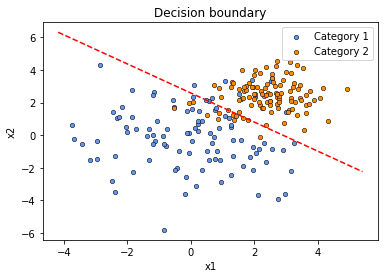

In [33]:
show_decision_boundary(final_slope,final_intercept,x_train_u,y_train_u)


### Solution 2 B: Oversampling: Let's use the original loss but with more samples from category 2


In [27]:
all_minority_samples=xdata[xdata['category']==minority_class_flag]
oversampled_data=xdata.copy()
for i in range(5):
    oversampled_data=oversampled_data.append(all_minority_samples)


data=oversampled_data.copy()
y=data.pop('category')
X=data
x_train_o, x_eval_o, y_train_o, y_eval_o = train_test_split(X,y,test_size=0.3, random_state = 42)

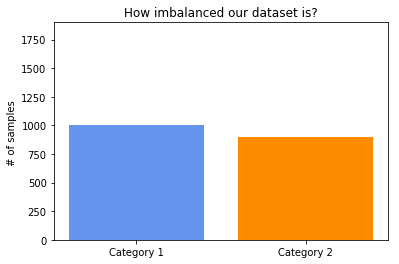

In [28]:
show_balance_of_classes(oversampled_data)

In [29]:
# the original eval set is used for predictions!
# using the original loss!
final_slope,final_intercept,eval_predictions=train(hinge_loss_svm,x_train_o,y_train_o,x_eval)


loss: [247.85559] slope: -1.8260431 intercept: 0.21824428 W 22.928246 41.867966 b 5.0039587
loss: [39.338177] slope: -1.8038021 intercept: 0.7007871 W 8.764952 15.810239 b 6.1423655
loss: [5.1111813] slope: -1.7384259 intercept: 2.3260405 W 3.0440984 5.2919393 b 7.080696
loss: [1.1545118] slope: -1.3573909 intercept: 4.9140058 W 1.4431038 1.9588559 b 7.0914207
loss: [0.98258996] slope: -1.0518318 intercept: 4.2517176 W 1.4872979 1.5643873 b 6.3235707
loss: [0.85510397] slope: -0.97436595 intercept: 3.9930542 W 1.4020993 1.3661578 b 5.598658
loss: [0.7487148] slope: -0.9787667 intercept: 3.8993578 W 1.2650983 1.2382361 b 4.933071
loss: [0.65800005] slope: -0.9628286 intercept: 3.7491465 W 1.1517663 1.1089535 b 4.3181405
loss: [0.58233416] slope: -0.9723713 intercept: 3.6387095 W 1.0326682 1.0041369 b 3.7575798
loss: [0.52219105] slope: -0.992449 intercept: 3.5583553 W 0.9161081 0.90919054 b 3.259838
loss: [0.47471276] slope: -0.97530025 intercept: 3.391614 W 0.83061004 0.8100942 b 2.817

In [30]:
print(classification_report(y_eval, eval_predictions, target_names=['Category 1','Category 2']))

              precision    recall  f1-score   support

  Category 1       0.99      0.82      0.89       307
  Category 2       0.38      0.92      0.54        38

   micro avg       0.83      0.83      0.83       345
   macro avg       0.69      0.87      0.72       345
weighted avg       0.92      0.83      0.86       345



<p style="color:green">With oversampling we have similar results again as with the weighted loss</p>
So this means, just by oversampling the same data all the time we could reach a better result!<br/>
Lets draw the decision boundary:

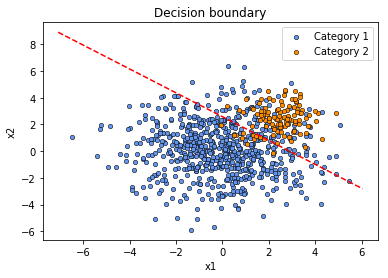

In [37]:
show_decision_boundary(final_slope,final_intercept)


### Solution 3: SMOTE and ADASYN
Readings:<br>
https://www.researchgate.net/publication/287601878_A_Novel_Boundary_Oversampling_Algorithm_Based_on_Neighborhood_Rough_Set_Model_NRSBoundary-SMOTE <br>
https://medium.com/coinmonks/smote-and-adasyn-handling-imbalanced-data-set-34f5223e167 <br>

implementation: <br>
https://github.com/scikit-learn-contrib/imbalanced-learn

### Let's look at first SMOTE

In [39]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()

data=xdata.copy()
y=data.pop('category')
X=data
x_smote,y_smote = sm.fit_sample(X, y)

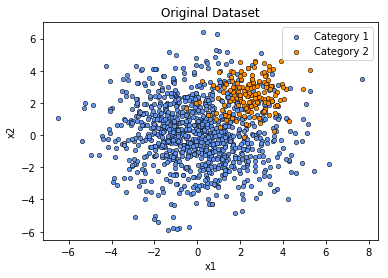

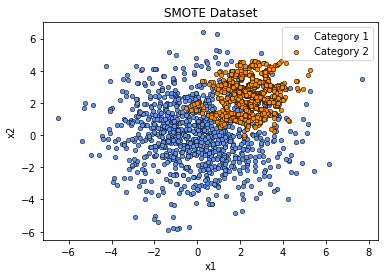

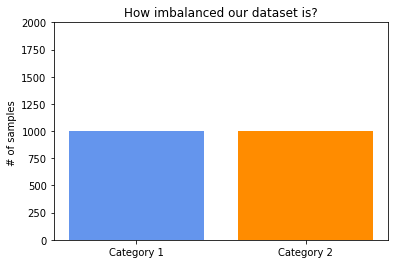

In [40]:
# result is 
smote_data=pd.DataFrame(data=[x_smote[:,0],x_smote[:,1],y_smote]).transpose()
smote_data=smote_data.rename(index=str, columns={0: "x1", 1: "x2", 2:"category"})
plot_data_points(xdata)
plt.title("Original Dataset")
plot_data_points(smote_data)
plt.title("SMOTE Dataset")
show_balance_of_classes(smote_data)

In [41]:

x_train_smote, x_eval_smote, y_train_smote, y_eval_smote = train_test_split(x_smote,y_smote,test_size=0.3, random_state = 42)

# EVAL: SHOULD BE THE ORIGINAL X_EVAL
final_slope,final_intercept,eval_predictions=train(hinge_loss_svm,x_train_smote,y_train_smote,x_eval)

loss: [246.63553] slope: -1.8260388 intercept: 0.21822965 W 22.928484 41.8683 b 5.003675
loss: [39.28416] slope: -1.8027072 intercept: 0.6879971 W 8.80813 15.87848 b 6.059968
loss: [5.211393] slope: -1.7393278 intercept: 2.2448182 W 3.0926933 5.3792076 b 6.9425344
loss: [1.0987834] slope: -1.3782248 intercept: 4.945426 W 1.4148552 1.9499886 b 6.9970617
loss: [0.933887] slope: -1.0644544 intercept: 4.267105 W 1.4647127 1.5591199 b 6.250083
loss: [0.8128556] slope: -0.9871272 intercept: 4.000941 W 1.3852957 1.3674631 b 5.542486
loss: [0.7115682] slope: -0.9910763 intercept: 3.910137 W 1.251494 1.240326 b 4.893513
loss: [0.62576234] slope: -0.9863732 intercept: 3.7840135 W 1.1351511 1.1196827 b 4.2954273
loss: [0.5533266] slope: -0.99118423 intercept: 3.6692443 W 1.0211626 1.0121603 b 3.746895
loss: [0.49607036] slope: -1.0144676 intercept: 3.5934641 W 0.9074809 0.92061 b 3.2610002
loss: [0.4508456] slope: -1.0076998 intercept: 3.4485366 W 0.82030946 0.8266257 b 2.8288672
loss: [0.4164504

In [43]:
print(classification_report(y_eval, eval_predictions, target_names=['Category 1','Category 2']))

              precision    recall  f1-score   support

  Category 1       0.99      0.82      0.89       307
  Category 2       0.38      0.92      0.54        38

   micro avg       0.83      0.83      0.83       345
   macro avg       0.69      0.87      0.72       345
weighted avg       0.92      0.83      0.86       345



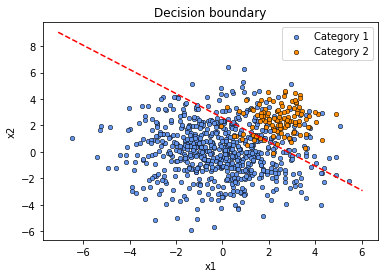

In [48]:
show_decision_boundary(final_slope,final_intercept)

### Let's look at ADASYN

In [49]:
from imblearn.over_sampling import ADASYN 
ada = ADASYN()

data=xdata.copy()
y=data.pop('category')
X=data
x_adasyn,y_adasyn = ada.fit_sample(X, y)

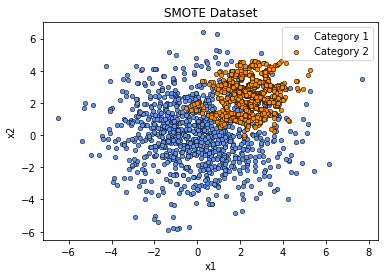

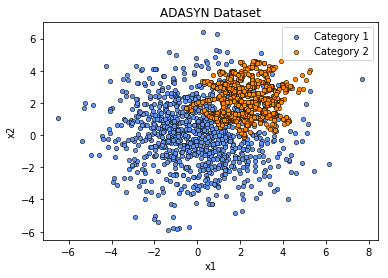

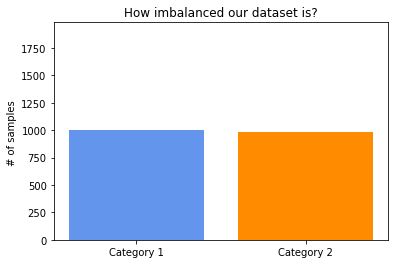

In [50]:
# the result is 
adasyn_data=pd.DataFrame(data=[x_adasyn[:,0],x_adasyn[:,1],y_adasyn]).transpose()
adasyn_data=adasyn_data.rename(index=str, columns={0: "x1", 1: "x2", 2:"category"})
plot_data_points(smote_data)
plt.title("SMOTE Dataset")
plot_data_points(adasyn_data)
plt.title("ADASYN Dataset")
show_balance_of_classes(adasyn_data)

In [51]:
x_train_adasyn, x_eval_adasyn, y_train_adasyn, y_eval_adasyn = train_test_split(x_adasyn,y_adasyn,test_size=0.3, random_state = 42)

# EVAL: SHOULD BE THE ORIGINAL X_EVAL
final_slope,final_intercept,eval_predictions=train(hinge_loss_svm,x_train_adasyn,y_train_adasyn,x_eval)

loss: [247.12549] slope: -1.8260417 intercept: 0.21823283 W 22.928381 41.86818 b 5.0037255
loss: [39.326622] slope: -1.8044385 intercept: 0.69154316 W 8.786326 15.854385 b 6.076124
loss: [5.178955] slope: -1.7448859 intercept: 2.277449 W 3.0642414 5.3467517 b 6.9786534
loss: [1.3407197] slope: -1.3459707 intercept: 4.573354 W 1.5032003 2.0232637 b 6.8746667
loss: [1.1198022] slope: -1.059561 intercept: 3.9743338 W 1.5066817 1.5964211 b 5.9880557
loss: [0.95272315] slope: -1.0140188 intercept: 3.7523665 W 1.3742201 1.393485 b 5.1565776
loss: [0.81279385] slope: -1.0065193 intercept: 3.6032467 W 1.2200689 1.2280229 b 4.3962092
loss: [0.7001108] slope: -1.0345153 intercept: 3.5233328 W 1.0551456 1.0915643 b 3.7176292
loss: [0.6114182] slope: -1.0328991 intercept: 3.3693511 W 0.9246018 0.9550204 b 3.115308
loss: [0.543321] slope: -1.0043122 intercept: 3.1478214 W 0.8219717 0.8255162 b 2.5874202
loss: [0.4949641] slope: -0.98603404 intercept: 2.9520757 W 0.72658575 0.7164383 b 2.144936
loss

In [52]:
print(classification_report(y_eval, eval_predictions, target_names=['Category 1','Category 2']))

              precision    recall  f1-score   support

  Category 1       0.99      0.79      0.88       307
  Category 2       0.36      0.95      0.52        38

   micro avg       0.81      0.81      0.81       345
   macro avg       0.67      0.87      0.70       345
weighted avg       0.92      0.81      0.84       345



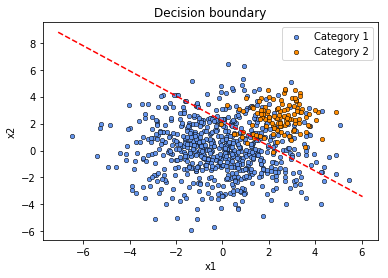

In [53]:
show_decision_boundary(final_slope,final_intercept)